In [119]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
def create_shape(dim, j):
    assert(j in [0, 1, 2, 3])
    assert(dim in [2, 3])
    assert(j <= dim)
    if dim == 3:
        V = [[1, 1, 1],
             [1, -1, -1],
             [-1, 1, -1],
             [-1, -1, 1]]
        if j == 0:
            E = [[0],
                 [1],
                 [2],
                 [3]]
        elif j == 1:
            E = [[0,1],
                 [0,2],
                 [0,3],
                 [1,2],
                 [1,3],
                 [2,3]]
        elif j == 2:
            E = [[0,1,2],
                 [0,1,3],
                 [0,2,3],
                 [1,2,3]]
        elif j == 3:
            E = [[0,1,2,3]]
    elif dim == 2:
        V = [[.25, .25],
             [.75, .25],
             [.50, .75]]
        if j == 0:
            E = [[0],
                 [1],
                 [2]]
        elif j == 1:
            E = [[0,1],
                 [0,2],
                 [1,2]]
        elif j == 2:
            E = [[0,1,2]]
    V = torch.FloatTensor(V)
    E = torch.LongTensor(E)
    
    # normalize V
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

In [41]:
# random hull
def rand_hull(n_points, dim):
    V = np.random.rand(n_points, dim)
    mesh = Delaunay(V)
    E = mesh.simplices
    V, E = torch.FloatTensor(V), torch.LongTensor(E)
    # normalize V
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

In [42]:
def simplex_content(V, E):
    """
    Compute the content of simplices in a simplicial complex
    :param V: vertex tensor. float tensor of shape (n_vertex, n_dims)
    :param E: element tensor. int tensor of shape (n_elem, j+1)
    """
    ne = E.shape[0] # number of elements
    nppe = E.shape[1] # number of points per element
    assert(nppe in [1, 2, 3, 4]) # points, lines, tri or tet
    if nppe == 1: # points
        return torch.ones(ne, 1, dtype=V.dtype)
    if nppe == 2: # lines
        P = V[E]
        Len = torch.norm(P[:, 1:] - P[:, :-1], dim=-1)
        return Len
    elif nppe == 3: # triangles
        E_ = torch.cat([E, E[:, 0:1]], dim=-1)
        P = V[E_]
        L = torch.norm(P[:, 1:] - P[:, :-1], dim=-1)
        S = torch.sum(L, dim=-1, keepdim=True) / 2
        Area = torch.sqrt(S*(S-L[:, 0:1])*(S-L[:, 1:2])*(S-L[:, 2:])) # Heron's Formula
        return Area
    elif nppe == 4: # tetrahedron
        P = V[E]
        Va = P[:, 1] - P[:, 0]
        Vb = P[:, 2] - P[:, 0]
        Vc = P[:, 3] - P[:, 0]
        Vol = torch.abs(torch.einsum('ab,ab->a', (Va, torch.cross(Vb, Vc, dim=-1))) / 6)
        return Vol
        

In [309]:
import torch
from torch.autograd import Function

from utils import fftfreqs, simplex_content, triangulate_interior, permute_seq
from math import ceil, factorial


class DDSL(Function):
    """
    Fourier transform for signal defined on a j-simplex set in R^n space
    :param V: vertex tensor. float tensor of shape (n_vertex, n_dims)
    :param E: element tensor. int tensor of shape (n_elem, j or j+1)
              if j cols, triangulate/tetrahedronize interior first.
    :param D: int ndarray of shape (n_vertex, n_channel)
    :param res: n_dims int tuple of number of frequency modes
    :param t: n_dims tuple of period in each dimension
    :param j: dimension of simplex set
    :param mode: normalization mode.
                 'density' for preserving density, 'mass' for preserving mass
    :return: F: ndarray of shape (res[0], res[1], ..., res[-1]/2, n_channel)
                last dimension is halfed since the signal is assumed to be real
    """
    @staticmethod
    def forward(ctx, V, E, D, res, t, j, elem_batch=100, mode='density'):
        ## boiler-plate
        ctx.res = res
        ctx.t = t
        ctx.j = j
        ctx.mode = mode
        ctx.save_for_backward(V, E, D)

        ## compute frequencies F
        n_dims = V.shape[1]
        assert(n_dims == len(res))  # consistent spacial dimensionality
        assert(E.shape[0] == D.shape[0])  # consistent vertex numbers
        assert(mode in ['density', 'mass'])

        # number of columns in E
        subdim = E.shape[1] == j and n_dims == j
        assert (E.shape[1] == j+1 or subdim)
        if subdim:
            E = triangulate_interior(V, E)
        n_elem = E.shape[0]
        n_vert = V.shape[0]
        n_channel = D.shape[1]

        # frequency tensor
        omega = fftfreqs(res).to(V.device) # [dim0, dim1, dim2, d]
        omega[tuple([0] * n_dims)] += 1 # will get rid of this

        # normalize frequencies
        for dim in range(n_dims):
            omega[..., dim] *= 2 * np.pi / t[dim]

        # initialize output F
        F_shape = list(omega.shape)[:-1]
        F_shape += [n_channel, 2]
        F = torch.zeros(*F_shape, dtype=V.dtype, device=V.device) # [dimX, dimY, dimZ, n_chan, 2] 2: real/imag

        # compute content array
        C = simplex_content(V, E) # [n_elem, 1]

        # compute element-point tensor
        P = V[E] # [n_elem, j+1, d]

        # loop over element batches
        for idx in range(ceil(n_elem/elem_batch)):
            id_start = idx * elem_batch
            id_end = min((idx+1) * elem_batch, n_elem)
            X = P[id_start:id_end] # [elem_batch, j+1, d]
            Di = D[id_start:id_end] # [elem_batch, n_channel]
            Ci = C[id_start:id_end] # [elem_batch, 1]
            CDi = Ci * Di # [elem_batch, n_channel]
            sig = torch.einsum('bjd,...d->bj...', (X, omega)) 
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1]
            esig = torch.stack((torch.cos(sig), torch.sin(sig)), dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            denom = torch.ones_like(sig) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            for dim in range(1, j+1):
                seq = permute_seq(dim, j+1)
                denom *= sig - sig[:, seq]
            tmp = torch.sum(esig / denom, dim=1) # [elem_batch, dimX, dimY, dimZ, 1, 2]
            CDi.unsqueeze_(-1) # [elem_batch, n_channel, 1]
            for _ in range(n_dims): # unsqueeze to broadcast
                CDi.unsqueeze_(dim=1) # [elem_batch, 1, 1, 1, n_channel, 1]
            tmp *= CDi # [elem_batch, dimX, dimY, dimZ, n_channel, 2]
            Fi = torch.sum(tmp, dim=0, keepdim=False) # [dimX, dimY, dimZ, n_channel, 2]
            Fi[tuple([0] * n_dims)] = - 1 / factorial(j) * torch.sum(CDi, dim=0).unsqueeze(dim=-1)
            Fi *= factorial(j)
            # Fi *= 1j**j # [dimX, dimY, dimZ, n_chan, 2] 2: real/imag
            F += Fi
        if j == 0:
            pass
        elif j == 1:
            F = F[..., [1, 0]]
            F[..., 0] = -F[..., 0]
        elif j == 2:
            F *= -1
        elif j == 3:
            F = F[..., [1, 0]]
            F[..., 1] = -F[..., 1]

        if mode == 'density':
            if not np.array_equal(res, res[0]*np.ones(len(res))):
                print("WARNING: density preserving mode not correctly implemented if not all res are equal")
            F *= res[0] ** j
        return F

    @staticmethod
    def backward(ctx, dF):
        V, E, D = ctx.saved_tensors
        dV = ddsl_cuda.backward(dF, V, E, D, res, t, j, mode=ctx.mode)
        
        n_dims = V.shape[1]
        assert(n_dims == 2) # backwards not implemented for other dims yet
        assert(ctx.j == 2) # not yet implemented for other simplices
        
        n_elem = E.shape[0]
        n_vert = V.shape[0]
        n_channel = D.shape[1]
        
        
        return dV, None, None, None, None, None, None


In [310]:
dim = 3
j = 3
npoints = 20
r = 64

# V, E = create_shape(dim=dim,j=j)
V, E = rand_hull(npoints, dim)
V += 1e-3 * torch.rand(V.shape)
D = torch.ones(E.shape[0], 1, dtype=V.dtype)
V.requires_grad = False

res = [r] * dim
t = [1] * dim

# V, E, D = V.cuda(), E.cuda(), D.cuda()

nuft = DDSL.apply
from time import time
t0 = time()
F = nuft(V, E, D, res, t, j, 2, "density")
print("Time Lapse: {}".format(time() - t0))

Time Lapse: 1.8905720710754395


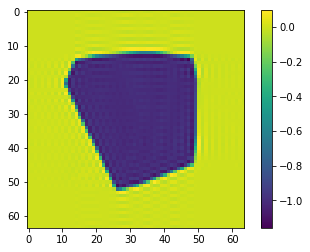

In [311]:
F = F.squeeze()
F[torch.isnan(F)] = 1

F_ = F.cpu().detach().numpy()
f_ = torch.irfft(F, dim, signal_sizes=res).squeeze().cpu().detach().numpy()
plt.figure()
plt.imshow(f_[:, 32, :])
# plt.imshow(f_)

# plt.imshow(np.fft.ifftshift(F_[:, :, 0], [0]))
plt.colorbar()
plt.show()

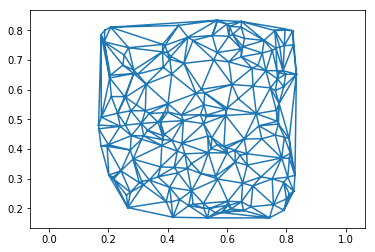

In [296]:
points = V.numpy()
simplices = E.numpy()
plt.triplot(points[:,0], points[:,1], simplices.copy())
plt.axis('equal')
plt.show()

In [282]:
print(F_.shape)

(128, 65, 2)
